In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from model import get_resnet
from dataset import get_dataset
import tensorflow_probability as tfp
from tqdm.notebook import tqdm
from tensorflow.keras import mixed_precision
from tensorflow.keras.layers import Layer, Conv2D
from sparse_conv2d import SparseConv2D
from utils import copy_layer, get_layer_model, get_weight, Eval, find_compression
import tensorly as tl
from tensorly.decomposition import partial_tucker
import utils

mixed_precision.set_global_policy("mixed_float16")
from tensorflow.keras.utils import register_keras_serializable

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060 Laptop GPU, compute capability 8.6


In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
SIZE = 224
base_model, model = get_resnet()
test_ds, val_ds = get_dataset(False, SIZE, 1, 16, True)
train_ds = get_dataset(True, SIZE, 1, 16, False)

In [4]:
biasl = [
    i
    for i, l in enumerate(base_model.layers)
    if (isinstance(l, Conv2D) and l.bias is not None)
]

In [5]:
default3 = [50.0, 70.3125, 54.6875, 29.6875, 48.4375, 31.25, 43.75, 20.3125, 54.6875, 54.6875, 50.0, 54.6875, 35.9375, 35.9375, 75.0, 32.8125]

In [6]:
model.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
base_accuracy = model.evaluate(test_ds)[1]
model.evaluate(val_ds)

313/313 [==============================] - 6s 19ms/step - loss: 0.8440 - accuracy: 0.7570


[0.8440498113632202, 0.7570000290870667]

In [7]:
pairs = [(0, 1.1240769335380003),
 (1, 0.4971613270000001),
 (16, 6.409053741367442),
 (0, 4.05549767727027),
 (4, 3.3687178403672),
 (0, 4.05549767727027),
 (8, 9.328945168781898),
 (0, 4.05549767727027),
 (4, 7.7249296237955996),
 (4, 5.366966478629633),
 (0, 4.05549767727027),
 (0, 4.05549767727027),
 (2, 11.38016623053183),
 (0, 17.785374327443208),
 (0, 4.05549767727027),
 (0, 4.05549767727027)]

In [8]:
bias3 = [i for i in biasl if base_model.layers[i].kernel.shape[0] == 3]

In [9]:
# for b, (r,s) in zip(bias3[::-1], pairs):
#     l = base_model.layers[b]
#     k = l.kernel.numpy()
#     if r:
#         rank = [r,r]
#         (core, factors), _ = partial_tucker(
#             k, modes=(2,3), rank=rank, init="svd"
#         )
#         new_w = tl.tenalg.multi_mode_dot(core, factors, modes=(2,3))
#     else:
#         new_w = np.zeros(k.shape)
#     t = np.percentile(abs(new_w-k), 100-s)
#     mask = abs(new_w-k) > t
#     new_w[mask] = k[mask]
#     l.set_weights([new_w, l.bias.numpy()])
#     model.evaluate(test_ds)

In [10]:
def get_decomp_weight(layer, rank=1, mode="both"):
    if mode == "both":
        modes = [2, 3]
    elif mode == "first":
        modes = [2]
    elif mode == "last":
        modes = [3]
    else:
        raise Exception()
    sz = np.prod(layer.output_shape[1:-1])
    kshape = layer.kernel.shape
    if mode == 'both':
        if isinstance(rank, int):
            rank = [rank,rank]
        return sz * (np.prod(kshape[:2]) * np.prod(rank) + rank[0] * kshape[-2] + rank[1] * kshape[-1])
    elif mode == "first":
        return sz * (np.prod(kshape[:2]) * kshape[-1] * rank + kshape[-2] * rank)
    else:
        return sz * (np.prod(kshape[:2]) * kshape[-2] * rank + kshape[-1] * rank)

In [11]:
dweights = []
bweights = []
for l in tqdm(biasl):
    la = base_model.layers[l]
    dweights.append(utils.get_weight(la))
    # [la.kernel.shape[-2] // 4, la.kernel.shape[-1] // 4]
    bweights.append(get_decomp_weight(la, 4, mode="both"))

  0%|          | 0/53 [00:00<?, ?it/s]

In [12]:
def test_rank(layer, weights, rank):
    (core, factors), _ = partial_tucker(
        weights[0], modes=[2, 3], rank=rank, init="svd"
    )
    new_w = tl.tenalg.multi_mode_dot(core, factors, modes=[2, 3])
    l.set_weights([new_w, weights[1]])
    _, acc = model.evaluate(test_ds, verbose=0)
    return acc, new_w

In [13]:
p = sum([get_weight(base_model.layers[i]) for i in biasl if base_model.layers[i].kernel.shape[0] == 3]) / sum(get_weight(base_model.layers[i]) for i in biasl)
print(f"Percentage of 3x3 convolutions: {p*100:.2f}%")

Percentage of 3x3 convolutions: 47.97%


In [14]:
bias3 = [i for i in biasl if base_model.layers[i].kernel.shape[0] == 3]
factors = utils.get_weights(bias3, base_model) * 0.1
# because they all the same
factor = factors[0]
arrs = []

In [15]:
bias3

[10, 22, 32, 42, 54, 64, 74, 84, 96, 106, 116, 126, 136, 146, 158, 168]

In [16]:
l = base_model.layers[bias3[-2]]

In [17]:
e = Eval(model, test_ds, tqdm(total=len(bias3)), base_accuracy)

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
pairs = []
for i in bias3:
    l = base_model.layers[i]
    ws, pair = find_compression(l, e)
    pairs.append(pair)
    l.set_weights([ws, l.bias.numpy()])
    _, acc = model.evaluate(test_ds)
    e.base_accuracy = acc
    e.pbar.update(1)

Testing prop: 0... found min = 8.6504%, max = 25.0000%... everything sucks, returning... final sparsity: 100.00%
Testing prop: 1... found min = 8.6504%, max = 25.0000%... final sparsity: 25.00%
Testing prop: 2... found min = 3.0288%, max = 24.5795%... final sparsity: 24.58%
Testing prop: 4... everything sucks, returning... final sparsity: 100.00%
Testing prop: 8... found min = 3.0288%, max = 21.0314%... everything sucks, returning... final sparsity: 100.00%
Testing prop: 16... found min = 2.3298%, max = 13.5661%... everything sucks, returning... final sparsity: 100.00%
Testing prop: 32... Breaking.
Best pair: decomposition = 2, sparsity = 24.579536, score: 0.2537
313/313 [==============================] - 6s 20ms/step - loss: 0.8815 - accuracy: 0.7398
Testing prop: 0... found min = 8.6504%, max = 25.0000%... everything sucks, returning... final sparsity: 100.00%
Testing prop: 1... found min = 8.6504%, max = 25.0000%... everything sucks, returning... final sparsity: 100.00%
Testing prop

In [16]:
pairs

[(0, 1.1240769335380003),
 (1, 0.4971613270000001),
 (16, 6.409053741367442),
 (0, 4.05549767727027),
 (4, 3.3687178403672),
 (0, 4.05549767727027),
 (8, 9.328945168781898),
 (0, 4.05549767727027),
 (4, 7.7249296237955996),
 (4, 5.366966478629633),
 (0, 4.05549767727027),
 (0, 4.05549767727027),
 (2, 11.38016623053183),
 (0, 17.785374327443208),
 (0, 4.05549767727027),
 (0, 4.05549767727027)]

In [17]:
pbar = tqdm(total=len(bias3))
for idx in bias3[::-1]:
    l = base_model.layers[idx]
    c = l.kernel.shape[-1]
    default_b, default_w = l.bias.numpy(), l.kernel.numpy()
    props = [0] + [2**i for i in range(int(np.log2(c)))] + [3*c//4]
    spars = [0] + [0.1 * 2**i for i in range(9)]
    acc_arr = np.zeros((len(props), len(spars)))
    t_ops = np.zeros((len(props), len(spars)))
    s_ops = np.zeros((len(props), len(spars)))
    best_i, best_j, best_w = 0, 0, default_w
    best_prop = 1
    for i, t_cur in enumerate(props):
        if t_cur != 0:
            rank = [t_cur, t_cur]
            (core, factors), _ = partial_tucker(
                default_w, modes=[2, 3], rank=rank, init="svd"
            )
            new_w = tl.tenalg.multi_mode_dot(core, factors, modes=[2, 3])
        else:
            new_w = np.zeros(default_w.shape)
        for j, s in enumerate(spars):
            s_w = new_w.copy()
            t = np.percentile(abs(s_w-default_w), 100-s)
            mask = abs(s_w-default_w) > t
            s_w[mask] = default_w[mask]
            l.set_weights([s_w, default_b])
            _, acc = model.evaluate(test_ds, verbose=0)
            acc_arr[i,j] = acc
            s_ops[i,j] = get_weight(l) * s/100
            t_ops[i,j] = get_decomp_weight(l, rank) if t_cur != 0 else 0
            tot_w = s_ops[i,j] + t_ops[i,j]
            if acc >= base_accuracy - 0.001:
                perw = tot_w / get_weight(l)
                if perw < best_prop:
                    best_i, best_j = i,j
                    best_w = s_w
                    best_prop = perw
                    print(perw)
    print(f"{best_prop:.4f}: [{best_i}, {best_j}], {props[best_i]}, {spars[best_j]}: accuracy = {acc_arr[best_i, best_j]:.5f}")
    arrs.append((acc_arr, t_ops, s_ops))
    np.save(f"layers/layer{idx}", best_w, acc_arr, (t_ops + s_ops) / get_weight(l))
    if best_prop != 100:
        l.set_weights([best_w, default_b])
    else:
        l.set_weights([default_w, default_b])
    pbar.update(1)

  0%|          | 0/16 [00:00<?, ?it/s]

0.128


KeyboardInterrupt: 

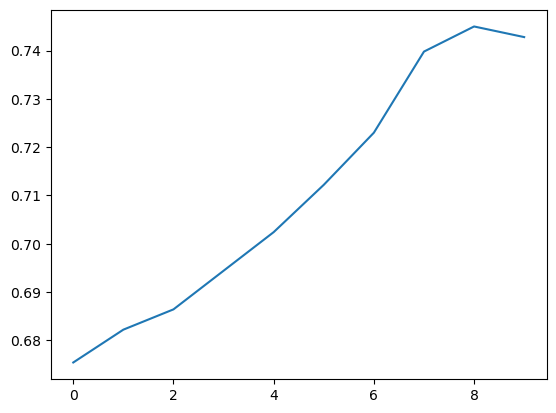

In [22]:
plt.plot(arrs[0][0][4,:])

In [16]:
from glob import glob
for idx in bias3:
    a = np.load(f"layers/layer{idx}.npy")
    l = base_model.layers[idx]
    l.set_weights([a, l.bias.numpy()])

In [17]:
model.evaluate(val_ds)

313/313 [==============================] - 6s 19ms/step - loss: 0.8483 - accuracy: 0.7504


[0.8482937216758728, 0.7504000067710876]

In [13]:
indices = thing = [(6,8),(7,4),(5,9),(7,8),(6,8),(7,8),(3,8),(6,8),(8,0),(8,2),(7,3),(3,8),(9,9),(6,9),(10,2),(3,8)]

In [14]:
for idx, t in zip(bias3, thing):
    l = base_model.layers[idx]
    c = l.kernel.shape[-1]
    default_b, default_w = l.bias.numpy(), l.kernel.numpy()
    props = [0] + [2**i for i in range(int(np.log2(c)))] + [3*c//4]
    spars = [0] + [0.1 * 2**i for i in range(9)]
    prop, spar = props[t[0]], spars[t[1]]
    print(prop, spar)
    rank = [prop, prop]
    (core, factors), _ = partial_tucker(
        default_w, modes=[2, 3], rank=rank, init="svd"
    )
    new_w = tl.tenalg.multi_mode_dot(core, factors, modes=[2, 3])
    s_w = new_w[:]
    t = np.percentile(abs(s_w-default_w), 100-s)
    mask = abs(s_w-default_w) > t
    s_w[mask] = default_w[mask]
    l.set_weights([s_w, default_b])
    _, acc = model.evaluate(test_ds, verbose=0)
    print(acc)

32 12.8
0.746399998664856
48 0.8
0.7437999844551086
16 25.6
0.7143999934196472
64 12.8
0.7124000191688538
32 12.8
0.7232000231742859
64 12.8
0.7206000089645386
4 12.8
0.7124000191688538
32 12.8
0.7120000123977661
128 0
0.7120000123977661
128 0.2
0.7107999920845032
64 0.4
0.7099999785423279
4 12.8
0.7111999988555908
192 25.6
0.7120000123977661
32 25.6
0.7063999772071838
384 0.2
0.7067999839782715
4 12.8
0.7003999948501587


In [15]:
model.evaluate(val_ds)

313/313 [==============================] - 6s 19ms/step - loss: 1.0263 - accuracy: 0.7034


[1.0263148546218872, 0.7034000158309937]

In [18]:
mins = []
for (accs, t_ops, s_ops), idx in zip(arrs, bias3):
    ops = t_ops + s_ops
    de = accs - base_accuracy
    if (de > 0).any():
        min_ops = np.min(ops[de > 0])
        mins.append(min_ops / get_weight(base_model.layers[idx]))
    else:
        mins.append(1)

In [19]:
np.mean(mins)

0.20014716075283062

In [26]:
x1 = []
x3 = []
for i in biasl:
    k = base_model.layers[i].kernel.shape
    if k[0] == 1:
        x1.append(np.prod(k))
    elif k[0] == 3:
        x3.append(np.prod(k))
np.sum(x3) / np.sum(x1 + x3) 

0.4827044025157233

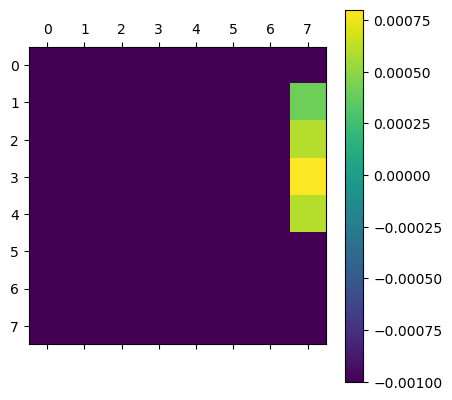

In [44]:
m = arrs[-2][0][1:-2,0:-2] - base_accuracy
m[m < 0] = -0.001
plt.matshow(m)
plt.colorbar()

In [43]:
(512*16+3*3*16*16+512*16+(512*512*3*3)*0.064)/(512*512*3*3)

0.07192100694444445

In [65]:
np.mean(default3)/100

0.4638671875

In [71]:
1 - sum(np.prod(base_model.layers[i].kernel.shape) * j for i,j in zip(bias3, np.array(mins))) / sum(np.prod(base_model.layers[i].kernel.shape) for i in bias3)

0.8556450465696255

In [28]:
[f"Kernel shape: {base_model.layers[l].kernel.shape} sparsity: {100*i:.2f}%" for l,i in zip(bias3, 1 - np.array(mins))]

['Kernel shape: (3, 3, 64, 64) sparsity: 86.83%',
 'Kernel shape: (3, 3, 64, 64) sparsity: 74.40%',
 'Kernel shape: (3, 3, 64, 64) sparsity: 74.40%',
 'Kernel shape: (3, 3, 128, 128) sparsity: 51.09%',
 'Kernel shape: (3, 3, 128, 128) sparsity: 75.39%',
 'Kernel shape: (3, 3, 128, 128) sparsity: 74.40%',
 'Kernel shape: (3, 3, 128, 128) sparsity: 89.26%',
 'Kernel shape: (3, 3, 256, 256) sparsity: 82.86%',
 'Kernel shape: (3, 3, 256, 256) sparsity: 87.20%',
 'Kernel shape: (3, 3, 256, 256) sparsity: 63.69%',
 'Kernel shape: (3, 3, 256, 256) sparsity: 88.09%',
 'Kernel shape: (3, 3, 256, 256) sparsity: 87.20%',
 'Kernel shape: (3, 3, 256, 256) sparsity: 74.40%',
 'Kernel shape: (3, 3, 512, 512) sparsity: 84.99%',
 'Kernel shape: (3, 3, 512, 512) sparsity: 93.51%',
 'Kernel shape: (3, 3, 512, 512) sparsity: 89.26%']

In [ ]:
from IPython.display import display, clear_output
from ipywidgets import widgets
def live_plot(mat, sp_arr, props, spars, base_accuracy, factor):
    fig, axs = plt.subplots(1,3, figsize=(24,8))
    axs[0].matshow(mat, cmap='viridis')
    for i in range(mat.shape[0]):
        for j in range(mat.shape[1]):
            axs[0].text(j, i, '{:.4f}'.format(mat[i, j]), ha='center', va='center',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2))
    axs[1].matshow(sp_arr, cmap='viridis')
    for i in range(sp_arr.shape[0]):
        for j in range(sp_arr.shape[1]):
            axs[1].text(j, i, '{:.4f}'.format(sp_arr[i, j]), ha='center', va='center',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2))
    score_arr = np.zeros(mat.shape)
    delta_arr = mat - base_accuracy
    for i in range(score_arr.shape[0]):
        for j in range(score_arr.shape[1]):
            score_arr[i,j] = utils.get_score(delta_arr[i,j], sp_arr[i,j], factor)
    axs[2].matshow(score_arr * (score_arr > 0).astype(int))
    for i in range(score_arr.shape[0]):
        for j in range(score_arr.shape[1]):
            axs[2].text(j, i, '{:.1f}'.format(score_arr[i, j]*100), ha='center', va='center',
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2))
    axs[2].set_yticks(np.arange(len(props)), props)
    axs[2].set_xticks(np.arange(len(spars)), spars)
    axs[2].set_xlabel("Sparsity (%)")
    axs[2].set_ylabel("Tucker factor (over 256)")
    axs[0].set_yticks(np.arange(len(props)), props)
    axs[0].set_xticks(np.arange(len(spars)), spars)
    axs[0].set_ylabel("Tucker factor (over 256)")
    axs[0].set_xlabel("Sparsity (%)")
    axs[1].set_yticks(np.arange(len(props)), props)
    axs[1].set_xticks(np.arange(len(spars)), spars)
    axs[1].set_ylabel("Tucker factor (over 256)")
    axs[1].set_xlabel("Sparsity (%)")
    axs[0].set_title(f"ACCURACY (%), BASE = {base_accuracy:.4f}", fontsize=20)
    axs[1].set_title("PERCENTAGE OF OPERATIONS", fontsize=20)
    axs[2].set_title("SCORE: > 0 if worth pruning", fontsize=20)
    fig.tight_layout()
    plt.show()

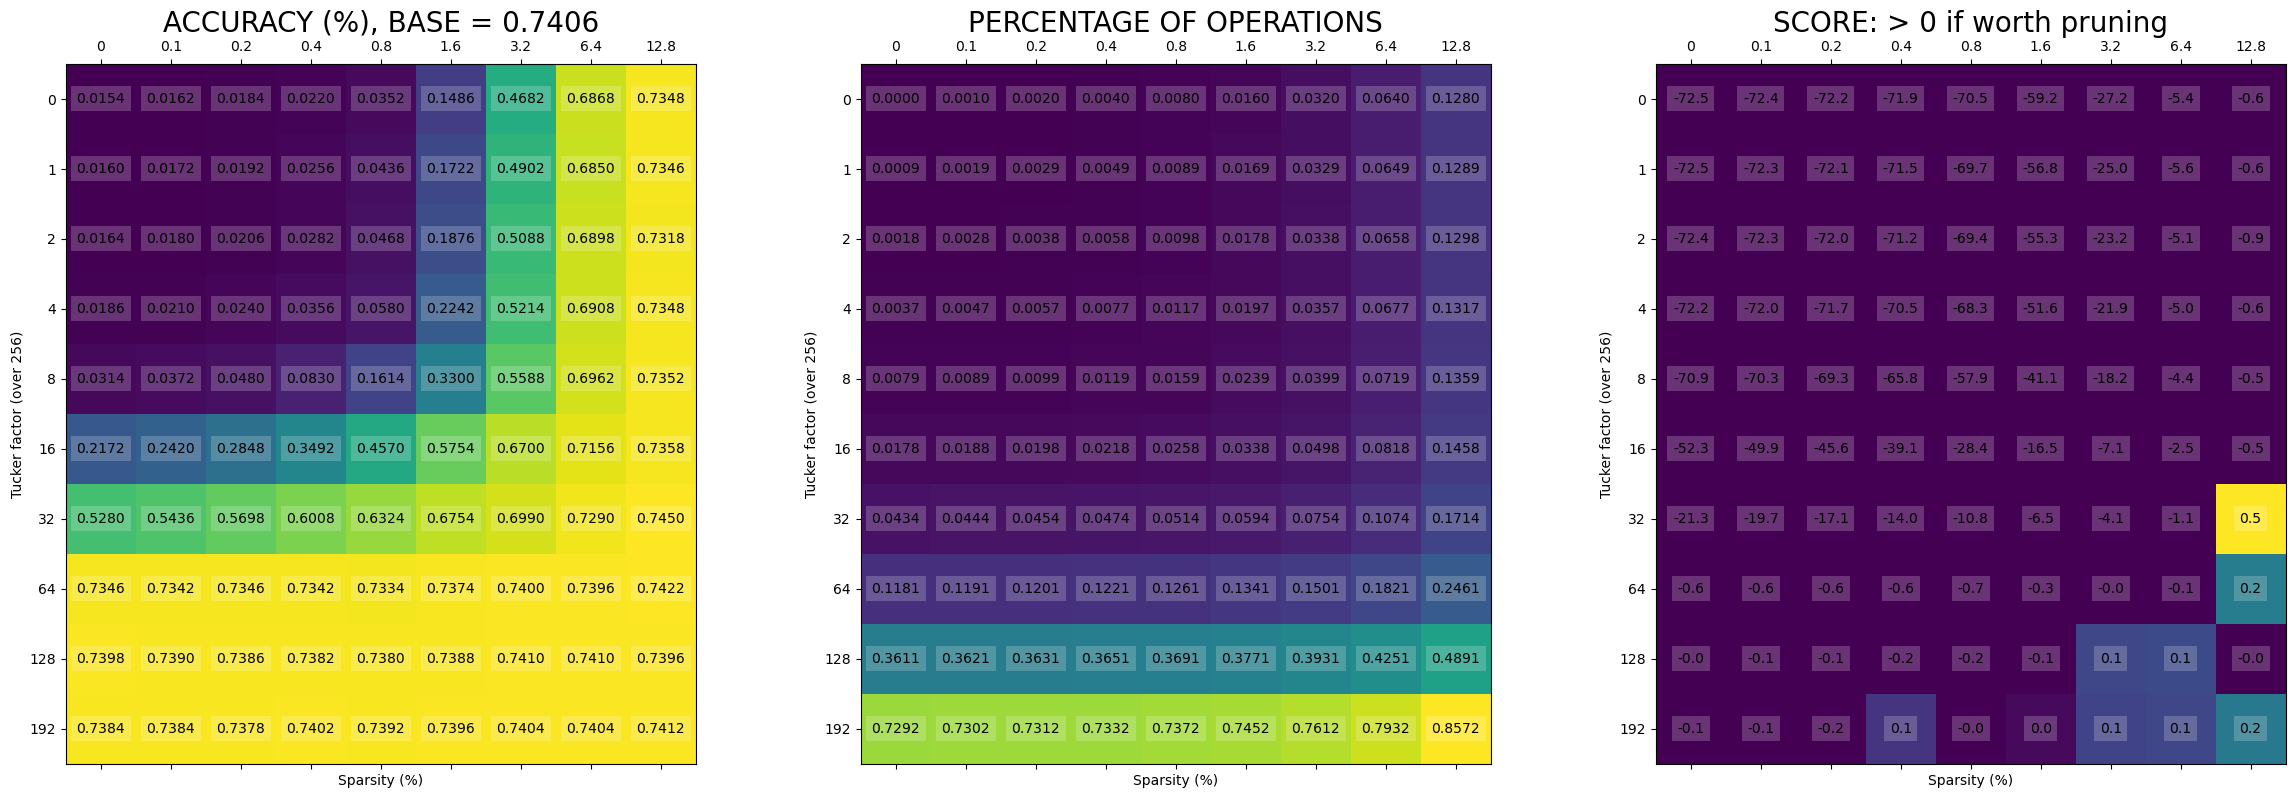

In [12]:
l = base_model.layers[biasl[25]]
c = l.kernel.shape[-1]
factor = utils.get_weights(biasl, base_model)[25] * 0.05
default_b, default_w = l.bias.numpy(), l.kernel.numpy()
props = [0] + [2**i for i in range(int(np.log2(c)))] + [3*c//4]
spars = [0] + [0.1 * 2**i for i in range(8)]
acc_arr = np.zeros((len(props), len(spars)))
t_ops = np.zeros((len(props), len(spars)))
s_ops = np.zeros((len(props), len(spars)))
pbar = tqdm(total=acc_arr.size)
for i, t_cur in enumerate(props):
    if t_cur != 0:
        rank = [t_cur, t_cur]
        (core, factors), _ = partial_tucker(
            default_w, modes=[2, 3], rank=rank, init="svd"
        )
        new_w = tl.tenalg.multi_mode_dot(core, factors, modes=[2, 3])
    else:
        new_w = np.zeros(default_w.shape)
    for j, s in enumerate(spars):
        s_w = new_w[:]
        t = np.percentile(abs(s_w-default_w), 100-s)
        mask = abs(s_w-default_w) > t
        s_w[mask] = default_w[mask]
        l.set_weights([s_w, default_b])
        _, acc = model.evaluate(test_ds, verbose=0)
        acc_arr[i,j] = acc
        s_ops[i,j] = get_weight(l) * s/100
        t_ops[i,j] = get_decomp_weight(l, rank) if t_cur != 0 else 0
        clear_output(wait=True)
        live_plot(acc_arr, (s_ops + t_ops) / get_weight(l), props, spars, base_accuracy, factor)
        pbar.update(1)

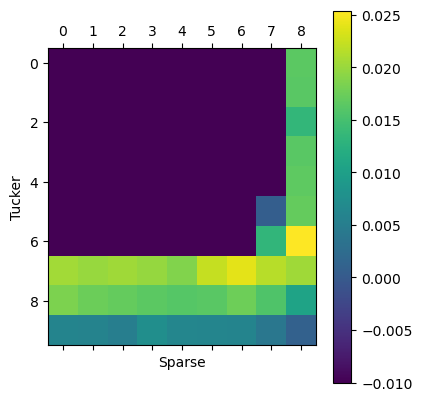

In [13]:
score_arr = np.zeros(acc_arr.shape)
delta_arr = acc_arr - base_accuracy
factor = utils.get_weights(biasl, base_model)[25] * 1
sparsity_arr = 1 - (s_ops * 2 + t_ops) / get_weight(base_model.layers[biasl[25]])
for i in range(score_arr.shape[0]):
    for j in range(score_arr.shape[1]):
        score_arr[i,j] = utils.get_score(delta_arr[i,j], sparsity_arr[i,j], factor)
plt.matshow(score_arr * (score_arr > 0).astype(int) + (score_arr <= 0).astype(int) * -0.01)
plt.xlabel("Sparse")
plt.ylabel("Tucker")
plt.colorbar()

In [11]:
def test_layer(l, pbar, base_accuracy, max_loss):
    c = l.kernel.shape[-1]
    t_min, t_cur, t_max = 1, c // 2, c
    default_b = l.bias.numpy()
    default_w = l.kernel.numpy()
    best_w, best_rank = default_w, None
    acc = base_accuracy
    pbar.write(f"{max_loss=}")
    while t_max - t_min > 1:
        pbar.write(f"Testing {t_cur=}...", end=" ")
        rank = [t_cur, t_cur]
        if get_decomp_weight(l, rank) / get_weight(l) > 1:
            pbar.write(f"Aborting: too large {rank=}")
            t_max = t_cur
            t_cur = (t_max + t_min) // 2
            continue
        acc, new_w = test_rank(l, [default_w, default_b], rank)
        pbar.write(f"{acc:.5f}")
        if base_accuracy - acc < max_loss:
            t_max = t_cur
            best_w, best_rank = new_w, rank
            base_accuracy = acc
        else:
            t_min = t_cur
        t_cur = (t_max + t_min) // 2
    if best_rank:
        pbar.write(f"{get_decomp_weight(l, best_rank) / get_weight(l)}")
    else:
        pbar.write("Nothing changed.")
    pbar.update(1)
    return acc, [best_w, default_b]

In [82]:
sparsity_arr[7,0]

0.6819444444444445

In [11]:
def find_props(l, pbar, base_accuracy, max_loss):
    c = l.kernel.shape[-1]
    default_b, default_w = l.bias.numpy(), l.kernel.numpy()
    best_w, best_rank = default_w, None
    acc = base_accuracy
    pbar.write(f"{max_loss=:.4f}")
    props = [2**i for i in range(int(np.log2(c)))] + [3*c//4]
    for t_cur in props:
        pbar.write(f"Testing {t_cur=}...", end=" ")
        rank = [t_cur, t_cur]
        if get_decomp_weight(l, rank) > get_weight(l):
            pbar.write(f"Aborting: too large {rank=}")
            break
        acc, new_w = test_rank(l, [default_w, default_b], rank)
        pbar.write(f"{acc:.5f}")
        if base_accuracy - acc < max_loss:
            best_w, best_rank = new_w, rank
            base_accuracy = acc
            break
    if best_rank:
        pbar.write(f"Percent used: {(get_decomp_weight(l, best_rank) * 100 / get_weight(l)):.2f}%")
    else:
        pbar.write("Nothing changed.")
    pbar.update(1)
    return acc, [best_w, default_b]

In [12]:
m = [base_model.layers[i].kernel.shape[0] == 3 for i in biasl]
biasl = np.array(biasl)

In [ ]:
losses_per_layer = utils.get_weights(biasl, base_model) * 0.01
pbar = tqdm(total=len(biasl[m]))
for i, max_loss in zip(biasl[m], losses_per_layer[m]):
    l = base_model.layers[i]
    base_accuracy, ws = find_props(l, pbar, base_accuracy, max_loss)
    l.set_weights(ws)

  0%|          | 0/16 [00:00<?, ?it/s]

max_loss=0.0003
Testing t_cur=1... 0.56080
Testing t_cur=2... 0.54940
Testing t_cur=4... 0.55380
Testing t_cur=8... 0.57180
Testing t_cur=16... 0.64420
Testing t_cur=32... 0.73100
Testing t_cur=48... 0.73900
Nothing changed.
max_loss=0.0003
Testing t_cur=1... 0.56860
Testing t_cur=2... 

In [49]:
lst = []
for i in tqdm(range(1, 64)):
    k = base_model.layers[biasl[-2]].kernel.numpy()
    (core, factors), errors = partial_tucker(k, modes=[2, 3], rank=[i, i], init="svd")
    k2 = tl.tenalg.multi_mode_dot(core, factors, modes=[2, 3])
    lst.append(np.sum((k2 - k) ** 2 > 0.001) / np.prod(k.shape))
plt.plot(lst)

  0%|          | 0/63 [00:00<?, ?it/s]

[]

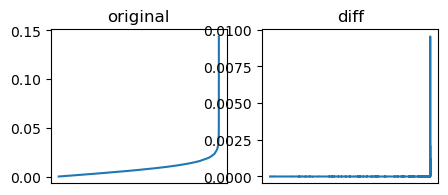

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(5, 2))
k = base_model.layers[biasl[-2]].kernel.numpy()
(core, factors), errors = partial_tucker(
    k, modes=[2, 3], rank=[1, 1], init="svd", mask=mask
)
k2 = tl.tenalg.multi_mode_dot(core, factors, modes=[2, 3])
a = sorted(((k - k2) ** 2).flatten())
ax[0].plot(np.sqrt(a))
ax[0].set_title(f"original")
ax[0].set_xticks([])
ax[1].plot(np.diff(np.sqrt(a)))
ax[1].set_title(f"diff")
ax[1].set_xticks([])

In [99]:
1 - 200 / len(a)

0.9999152289496528

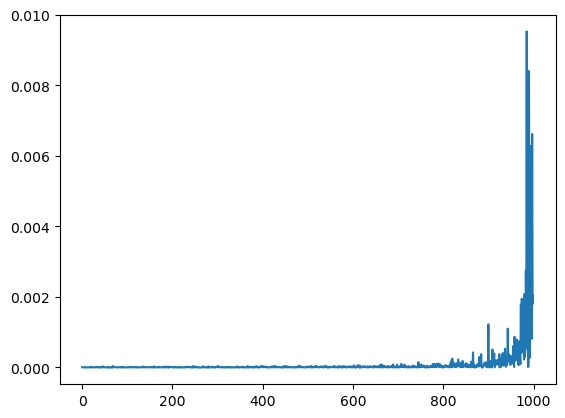

In [95]:
plt.plot(np.diff(np.sqrt(a))[-1000:])

In [105]:
n = 2
def_k = base_model.layers[biasl[-2]].kernel.numpy()
k = base_model.layers[biasl[-2]].kernel.numpy()
mask = np.ones(k.shape)
for i in tqdm(range(n)):
    (core, factors), errors = partial_tucker(k, modes=[2, 3], rank=[32, 32], init="svd")
    k2 = tl.tenalg.multi_mode_dot(core, factors, modes=[2, 3])
    diff = (k - k2) ** 2
    print(np.mean(diff))
    p = np.percentile(diff, 99.99152289496528)
    boo = diff > p
    mask[boo] = 0
    bmask = np.logical_not(mask.astype(bool))
    k[bmask] = k2[bmask]
diff = (k - k2) ** 2
print(np.mean(diff))
# (core, factors), errors = partial_tucker(
#     k, modes=[2, 3], rank=[1,1], init="svd", mask=mask
# )
# k2 = tl.tenalg.multi_mode_dot(core, factors, modes=[2, 3])
# t = np.percentile((k-k2)**2, 99.7)
# mask = ((k-k2)**2 < t).astype(np.int32)
# print(t)
# k2[np.logical_not(mask.astype(bool))] = k[np.logical_not(mask.astype(bool))]
# a = sorted(((k-k2)**2).flatten())
# ax[1].plot(a)
# ax[1].set_title("plot 1")

  0%|          | 0/2 [00:00<?, ?it/s]

8.9484194e-05
8.920397e-05
8.900999e-05


In [18]:
losses_per_layer = utils.get_weights(biasl, base_model)[1:] * 0.05
pbar = tqdm(total=len(biasl[1:]))
for i, max_loss in zip(biasl[1:], losses_per_layer[1:]):
    l = base_model.layers[i]
    in_c, out_c = l.kernel.shape[-2:]
    mi = min(in_c, out_c)
    ma = max(in_c, out_c)
    factor = ma // mi
    t_min, t_cur, t_max = 1, mi // 2, mi
    default_b = l.bias.numpy()
    default_w = l.kernel.numpy()
    best_w = default_w
    while t_max - t_min > 1:
        pbar.write(f"Testing {t_cur=}...", end=" ")
        rank = [t_cur, t_cur * factor] if out_c > in_c else [t_cur * factor, t_cur]
        (core, (factors)), _ = partial_tucker(
            default_w, modes=[2, 3], rank=rank, init="svd"
        )
        new_w = tl.tenalg.multi_mode_dot(core, factors, modes=[2, 3])
        l.set_weights([new_w, default_b])
        _, acc = model.evaluate(test_ds, verbose=0)
        pbar.write(f"{acc:.5f}")
        if base_accuracy - acc < max_loss:
            t_max = t_cur
            best_w = new_w
            base_accuracy = acc
        else:
            t_min = t_cur
        t_cur = (t_max + t_min) // 2
    pbar.update(1)
    l.set_weights([best_w, default_b])

  0%|          | 0/52 [00:00<?, ?it/s]

Testing t_cur=32... 0.73740
Testing t_cur=48... 0.73940
Testing t_cur=40... 0.73900
Testing t_cur=36... 0.73580
Testing t_cur=38... 0.73600
Testing t_cur=39... 0.73880
Testing t_cur=32... 0.73760
Testing t_cur=48... 0.73880
Testing t_cur=40... 0.73900
Testing t_cur=36... 0.73740
Testing t_cur=38... 0.73580
Testing t_cur=39... 0.73780
Testing t_cur=32... 

KeyboardInterrupt: 

  0%|          | 0/53 [00:00<?, ?it/s]

[1.0, 1.0, 1.0]


ValueError: too many values to unpack (expected 2)

In [23]:
sum(bweights) / sum(dweights)

0.5652717051842598

In [25]:
np.array(bweights) / np.array(dweights)

array([0.10884354, 0.5625    , 0.11805556, 1.125     , 1.125     ,
       1.125     , 0.11805556, 1.125     , 1.125     , 0.11805556,
       1.125     , 0.6875    , 0.11805556, 0.6875    , 1.125     ,
       1.125     , 0.11805556, 1.125     , 1.125     , 0.11805556,
       1.125     , 1.125     , 0.11805556, 1.125     , 0.6875    ,
       0.11805556, 0.6875    , 1.125     , 1.125     , 0.11805556,
       1.125     , 1.125     , 0.11805556, 1.125     , 1.125     ,
       0.11805556, 1.125     , 1.125     , 0.11805556, 1.125     ,
       1.125     , 0.11805556, 1.125     , 0.6875    , 0.11805556,
       0.6875    , 1.125     , 1.125     , 0.11805556, 1.125     ,
       1.125     , 0.11805556, 1.125     ])

In [314]:
def get_tucker_layer(layer, rank=1):
    (core, factors), rec_errors = partial_tucker(
        layer.kernel.numpy(), modes=[2, 3], rank=rank, init="svd", n_iter_max=1000
    )
    layer2 = copy_layer(layer)
    ws = layer.get_weights()
    ws[0] = tl.tenalg.multi_mode_dot(core, factors, modes=[2, 3])
    layer2.set_weights(ws)
    return layer2

In [335]:
o = [256, 256]
n = get_layer_model(base_model.layers[biasl[-1]], o)
l = get_tucker_layer(base_model.layers[biasl[-1]], o)

[0.42677014250302703, 0.42677014250302703, 0.42677014250302703]


In [297]:
rand = np.random.rand(1, *n.input_shape[1:])

In [298]:
out_test = n(rand)

In [299]:
out_test_2 = l(rand)

(array([   8.,    6.,   16.,   35.,   70.,  110.,  185.,  421.,  865.,
        4553., 1948.,  622.,  287.,  126.,   72.,   46.,   16.,   12.,
           5.,    5.]),
 array([-0.67102438, -0.60225695, -0.53348958, -0.46472216, -0.39595476,
        -0.32718736, -0.25841993, -0.18965253, -0.12088512, -0.05211771,
         0.01664969,  0.0854171 ,  0.15418451,  0.22295192,  0.29171932,
         0.36048675,  0.42925414,  0.49802154,  0.56678897,  0.63555634,
         0.70432377]),
 <BarContainer object of 20 artists>)

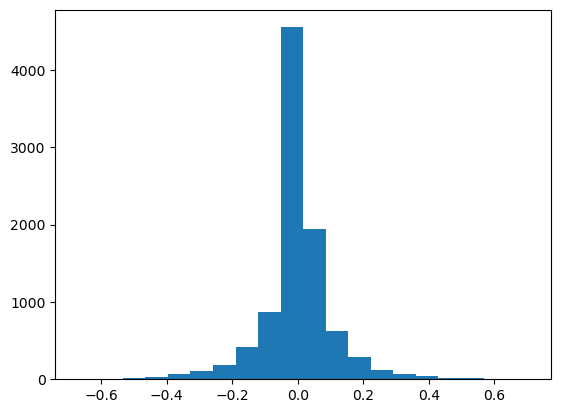

In [300]:
plt.hist((base_model.layers[biasl[0]].kernel).numpy().flatten(), bins=20)

(array([1.000e+00, 0.000e+00, 0.000e+00, 5.000e+00, 5.000e+00, 1.800e+01,
        3.800e+01, 8.000e+01, 2.070e+02, 5.810e+02, 1.823e+03, 4.753e+03,
        1.170e+03, 4.250e+02, 1.850e+02, 7.100e+01, 2.200e+01, 1.700e+01,
        6.000e+00, 1.000e+00]),
 array([-0.61412662, -0.55997527, -0.50582385, -0.45167246, -0.39752108,
        -0.34336972, -0.28921834, -0.23506694, -0.18091556, -0.12676418,
        -0.07261279, -0.01846141,  0.03568997,  0.08984136,  0.14399274,
         0.19814412,  0.25229549,  0.30644688,  0.36059827,  0.41474965,
         0.46890104]),
 <BarContainer object of 20 artists>)

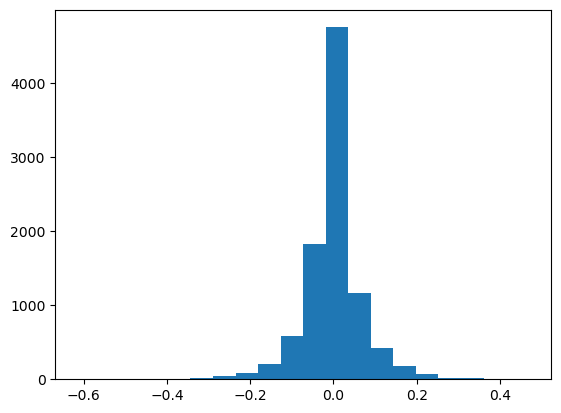

In [301]:
plt.hist((l.kernel - base_model.layers[biasl[0]].kernel).numpy().flatten(), bins=20)

In [289]:
out_test - out_test_2

<tf.Tensor: shape=(1, 112, 112, 64), dtype=float32, numpy=
array([[[[ 3.79234552e-05, -9.95397568e-06, -3.51620838e-06, ...,
           6.03497028e-06,  1.29565597e-05,  1.94460154e-05],
         [-2.50339508e-06, -2.20686197e-05,  8.99843872e-06, ...,
           1.92970037e-06, -9.20146704e-06,  8.72612000e-05],
         [ 3.02672386e-04, -1.00359321e-05,  4.75905836e-06, ...,
           4.63798642e-06, -2.68220901e-06, -1.49965286e-04],
         ...,
         [ 2.46435404e-04,  5.60283661e-06,  3.95043753e-06, ...,
           2.59354711e-05,  6.03776425e-06, -6.10053539e-05],
         [ 6.06104732e-05,  1.43423676e-06, -8.43778253e-07, ...,
           3.79607081e-06,  8.73953104e-06,  8.56518745e-05],
         [ 1.01968646e-04, -4.75719571e-06,  5.81052154e-06, ...,
           9.53674316e-06, -3.46451998e-06,  2.54064798e-05]],

        [[-7.00503588e-05,  1.74809247e-06,  2.37487257e-07, ...,
           3.29921022e-06,  9.76026058e-07,  7.30156898e-05],
         [ 1.28269196e-04,  5

In [122]:
def test_propagate(layer):
    in_shape = (1,) + layer.input_shape[1:]
    csts = tf.random.uniform(in_shape, dtype=tf.float16)
    mask = tf.cast(tf.random.uniform(in_shape, minval=0, maxval=1) > 0.8, tf.float16)
    prop = csts * mask
    inputs1 = [tf.random.uniform(in_shape, dtype=tf.float16) for _ in range(10)]
    inputs2 = [inp + prop for inp in inputs1]
    next_layer = layer.outbound_nodes[0].outbound_layer
    model2 = tf.keras.Model(inputs=layer.input, outputs=next_layer.output)
    outputs2 = [model2(inp) for inp in inputs2]
    watif = [model2(inp) for inp in inputs1]
    propagate_constants(layer, prop)
    outputs1 = [model2(inp) for inp in inputs1]
    for i, j, k in zip(outputs1, outputs2, watif):
        print(f"AFTER PROP {tf.math.reduce_max(tf.math.abs(i - j)).numpy()}")
        print(f"BEFORE PROP {tf.math.reduce_max(tf.math.abs(i - k)).numpy()}")
    print("TEST PASSED?")

In [9]:
ws = base_model.layers[biasl[-2]].get_weights()
default_w = ws[0]

In [16]:
approx_kernel, cr, (u, s, v) = svd_decomposition(default_w, 1)
ws[0] = approx_kernel
base_model.layers[biasl[-2]].set_weights(ws)

New kernel shapes: U.shape=(9, 1), S.shape=(1,), V.shape=(1, 262144)


In [24]:
u[:, :1] * s[:1]

array([[-4.0729094],
       [-4.8545084],
       [-4.3433247],
       [-5.0536504],
       [-5.1451955],
       [-5.3172846],
       [-4.239249 ],
       [-5.057133 ],
       [-4.522453 ]], dtype=float32)

In [55]:
base_model.layers[biasl[2]].kernel

<tf.Variable 'conv2_block1_2_conv/kernel:0' shape=(3, 3, 64, 64) dtype=float32, numpy=
array([[[[-1.75736193e-02,  5.30902483e-03, -1.39113341e-03, ...,
           5.26035437e-03,  1.13041867e-02,  7.81980902e-03],
         [ 1.58271659e-02,  2.15779664e-03,  4.06789873e-03, ...,
          -2.23483983e-03,  1.00913979e-02,  4.85334499e-03],
         [-1.30726518e-02,  2.56767496e-02, -7.79045234e-03, ...,
          -5.96159091e-03, -1.94626406e-03,  9.13294684e-03],
         ...,
         [-1.00161415e-03, -1.68226101e-02, -7.01747695e-03, ...,
          -3.64999543e-03, -1.23976739e-02,  1.09428251e-02],
         [ 2.42481381e-03,  4.87048645e-03, -1.29142514e-04, ...,
          -1.15170479e-02,  8.64238536e-04,  9.28544253e-03],
         [ 1.64120905e-02, -2.74309777e-02,  7.04734474e-02, ...,
          -1.74898170e-02, -1.75631884e-02, -1.10414233e-02]],

        [[-4.21591802e-04, -1.88555699e-02,  2.51010805e-02, ...,
           9.49396659e-03,  8.29766598e-03,  6.49292720e-03],
 

In [50]:
estimate_ranks(base_model.layers[biasl[2]])

0.000529975839612154
0.0005181130749322074


[2, 1]

In [43]:
model.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])
model.evaluate(test_ds)[1]

313/313 [==============================] - 17s 52ms/step - loss: 1.1930 - accuracy: 0.6766


0.6765999794006348

In [9]:
base_model.layers[biasl[0]].weights[1]

<tf.Variable 'conv1_conv/bias:0' shape=(64,) dtype=float32, numpy=
array([ 1.5829111e-09, -1.9272978e-10,  1.4708530e-10, -3.3394246e-11,
       -1.0394472e-09, -2.2981408e-09, -5.2869503e-10, -3.1592794e-11,
        1.8323251e-10, -4.9787726e-12,  2.1595645e-09, -1.3711804e-10,
       -1.2207793e-09, -1.8223448e-09, -2.4185174e-09, -6.8378503e-10,
       -4.4311914e-09,  4.9836388e-09, -3.2121539e-09,  2.0617887e-09,
        2.9162595e-09, -3.3172360e-09,  2.6172473e-10,  1.2767545e-10,
       -4.1365911e-09,  3.1397021e-10,  9.8183450e-10,  2.9085953e-10,
       -2.2326749e-09, -3.5986544e-11,  1.9345316e-09,  2.4486041e-10,
       -3.2064138e-09, -4.0993042e-10, -2.3597533e-09,  2.2365207e-10,
        5.3403926e-09, -2.1422985e-11,  3.5645006e-10,  2.6985592e-09,
        1.2312432e-09, -6.6246014e-10,  2.1508149e-09, -5.1568672e-10,
        7.6417521e-09,  3.6630692e-11,  1.2633139e-09,  1.3274220e-09,
       -3.3828521e-10,  9.2130364e-10,  1.1556998e-09,  6.8426276e-10,
        1.

In [10]:
ws = base_model.layers[biasl[2]].weights[0][0, 0].numpy()
U, s, Vt = np.linalg.svd(ws)

u = U[:, 0]
v = Vt[0, :]

uv_outer = np.outer(u, v)

In [11]:
m2 = tf.keras.Model(
    inputs=base_model.input, outputs=base_model.layers[biasl[18]].output
)
m1 = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)
m2 = m2(m1.output)
ftr_model = tf.keras.Model(m1.input, m2)
tot = 0
base_sum = tf.zeros(ftr_model.output_shape[1:])
for i, _ in tqdm(train_ds):
    base_sum += tf.reduce_sum(ftr_model(i), axis=0)
    tot += 8

  0%|          | 0/3125 [00:00<?, ?it/s]

In [12]:
mn = base_sum / tot
base_var = tf.zeros(ftr_model.output_shape[1:])
for i, _ in tqdm(train_ds):
    base_var += (tf.reduce_sum(ftr_model(i), axis=0) - mn) ** 2

  0%|          | 0/3125 [00:00<?, ?it/s]

In [17]:
std = (base_var ** (1 / 2)).numpy()

Explained variances: [0.76941519 0.88716981 0.93055049 0.95311582 0.97054633 0.98036249
 0.9882492  0.99432757 1.        ]


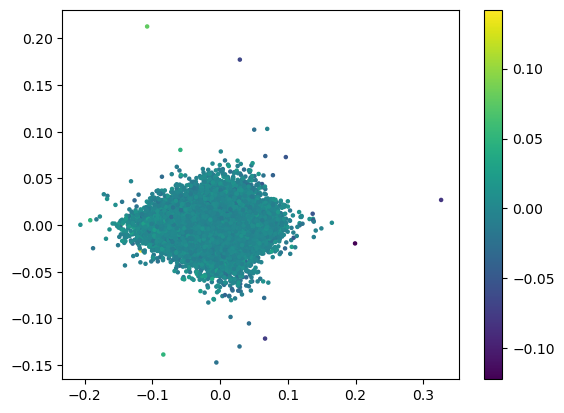

In [99]:
from sklearn.decomposition import PCA

num = 19
ws = base_model.layers[biasl[-2]].kernel.numpy().reshape(9, 512 * 512)
pca = PCA(n_components=9)
X_pca = pca.fit_transform(ws.T)
fig, ax = plt.subplots()
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], c=X_pca[:, 2], alpha=1, s=0.0000005 * 10000000
)
ax.scatter(X_pca[num::512, 0], X_pca[num::512, 1], c="r", alpha=0.01, s=0.003)
cbar = plt.colorbar(scatter)
print("Explained variances:", np.cumsum(pca.explained_variance_ratio_))

In [40]:
rat = []
for l in biasl:
    ker = base_model.layers[l].kernel.numpy()
    for i in range(ker.shape[-1]):
        rat.append(ker[..., i].mean() / ker[..., i].std())

In [55]:
rat = []
for l in biasl:
    ker = base_model.layers[l].kernel.numpy()
    lst = []
    for i in range(ker.shape[-1]):
        lst.append(ker[..., i].std())
    rat.append(lst)

In [62]:
max(min(a) for a in rat)

0.024125

(array([1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 6.000e+00,
        2.000e+00, 3.000e+00, 5.000e+00, 1.000e+01, 1.300e+01, 2.600e+01,
        6.000e+01, 8.700e+01, 1.740e+02, 3.830e+02, 6.880e+02, 1.394e+03,
        3.175e+03, 5.600e+03, 7.464e+03, 4.393e+03, 1.501e+03, 7.030e+02,
        3.660e+02, 2.000e+02, 1.350e+02, 6.500e+01, 3.000e+01, 2.700e+01,
        1.700e+01, 8.000e+00, 7.000e+00, 2.000e+00, 4.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([-0.88561571, -0.84392452, -0.80223334, -0.76054215, -0.71885091,
        -0.67715973, -0.63546854, -0.59377736, -0.55208617, -0.51039499,
        -0.46870378, -0.42701256, -0.38532138, -0.34363019, -0.30193901,
        -0.2602478 , -0.21855661, -0.17686541, -0.13517421, -0.09348303,
        -0.05179184, -0.01010064,  0.03159055,  0.07328174,  0.11497294,
         0.

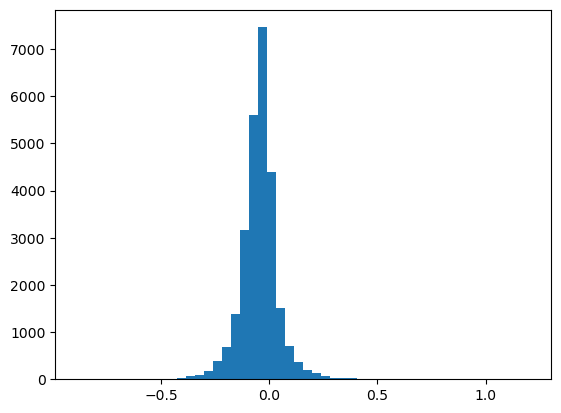

In [48]:
plt.hist(rat, bins=50)

In [21]:
std[..., :3]

array([[[1402.0634 ,  277.05515,  856.8213 ],
        [ 906.4848 ,  627.8533 ,  224.79303],
        [1004.0381 ,  792.38617,  171.6554 ],
        ...,
        [ 888.09143,  842.8633 ,  243.39551],
        [ 590.5929 ,  702.4002 ,  197.15424],
        [1375.5848 ,  902.0505 ,  368.6678 ]],

       [[ 454.10706,  238.71103,  688.17285],
        [ 230.7523 ,  276.0608 ,  253.06094],
        [ 338.90662,  565.8981 ,  234.01831],
        ...,
        [ 208.54507,  683.36755,  196.0076 ],
        [ 351.86945,  423.21213,  379.8189 ],
        [ 108.47937,  580.71344,  167.1974 ]],

       [[ 513.841  ,  226.74687,  515.8181 ],
        [ 237.30081,  307.38516,  123.15232],
        [ 306.69003,  538.383  ,  161.0986 ],
        ...,
        [ 190.38828,  687.75073,  216.13797],
        [ 237.16003,  381.9314 ,  205.42435],
        [ 296.00632,  628.6078 ,  195.81226]],

       ...,

       [[ 493.41083,  249.54584,  479.32376],
        [ 193.56863,  203.99065,  147.2173 ],
        [ 246.60405,  

In [5]:
for l in base_model.layers:
    if isinstance(l, SparseConv2D):
        expand_layer(l)

ValueError: Layer conv1_conv weight shape (64,) is not compatible with provided weight shape (56, 56, 64).

In [42]:
followed_by_conv2d = [
    i
    for i in conv_idx
    if type(base_model.layers[i]._outbound_nodes[0].outbound_layer)
    == keras.layers.Multiply
]

In [ ]:
xgrid = 3
ygrid = 3
fig, axs = plt.subplots(xgrid, ygrid, figsize=(16, 16))
for x in tqdm(range(xgrid)):
    for y in range(ygrid):
        m2 = tf.keras.Model(
            inputs=base_model.input,
            outputs=base_model.layers[biasl[x * ygrid + y]].output,
        )
        m1 = tf.keras.Model(inputs=model.input, outputs=model.layers[0].output)
        m2 = m2(m1.output)
        ftr_model = tf.keras.Model(m1.input, m2)
        tot = 8
        base_sum = tf.zeros(ftr_model.output_shape[1:])
        for i, _ in train_ds:
            base_sum += tf.reduce_sum(ftr_model(i), axis=0)
            tot += 8
        sh = base_sum / tot
        sh -= np.min(sh)
        sh /= np.max(sh)
        axs[x, y].matshow(sh)
        axs[x, y].axis("off")

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
A = base_sum.numpy()
U, s, Vt = np.linalg.svd(A)

u = U[:, 0]
v = Vt[0, :]

uv_outer = np.outer(u, v)

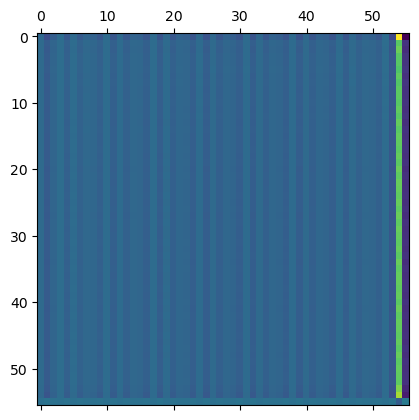

In [17]:
plt.matshow(uv_outer / tot)

In [18]:
is_bias = np.array([base_model.layers[i].use_bias for i in conv_idx])
from utils import get_weights

asort = np.argsort(get_weights(conv_idx, base_model))
is_bias[asort]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [21]:
np.array([base_model.layers[i].strides for i in conv_idx])

array([[2, 2],
       [1, 1],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [2, 2],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1, 1],
       [1,

In [5]:
def apply_mask(out, mask, weights):
    # return out * tf.cast(tf.logical_not(mask), tf.float32) + weights * tf.cast(
    #    mask, tf.float32
    # )
    return out * tf.cast(tf.logical_not(mask), tf.float16)

In [6]:
def call_wrapper(func, mask, weights):
    def wrapper(*args, **kwargs):
        return apply_mask(func(*args, **kwargs), mask, weights)

    return wrapper

In [7]:
def set_const(layer, mask, weights):
    if not "partial" in layer.name:
        layer.default_call = layer.call
        layer._name = f"partial_{layer.name}"
    layer._mask = mask
    layer.call = call_wrapper(layer.default_call, layer._mask, weights)

In [8]:
def test():
    weights = tf.random.uniform(shape=[112, 112, 24], minval=0, maxval=4)
    mask = tf.random.uniform(shape=[112, 112, 24], minval=0, maxval=1) > 0.2
    set_const(base_model.layers[conv_idx[0]], mask, weights)
    random_input = tf.random.uniform(shape=[1, 224, 224, 3])
    out1 = base_model.layers[conv_idx[0]].call(random_input)
    out2 = base_model.layers[conv_idx[0]].default_call(random_input)
    print(tf.reduce_sum(tf.cast(out1 == out2, tf.float32) / (112 * 112 * 24)))

In [9]:
def get_activations(model):
    activations = []
    for j, (d, t) in enumerate(test_ds):
        if j == 40:
            break
        activations.append(model(d))
    return tf.concat(activations, 0)

In [ ]:
for i in tqdm(conv_idx):
    m = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[i].output)
    activations = get_activations(m)
    stds = tf.math.reduce_mean(activations**2, 0)
    means = tf.math.reduce_mean(activations, 0)
    t_min, t_cur, t_max = 0, 50, 100
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    base_accuracy = model.evaluate(test_ds, verbose=0)[1]
    min_cutoff = 0.0
    print(f"BASELINE: {base_accuracy:.5f}")
    while t_max - t_min > 100 / 2**5:
        cutoff = tfp.stats.percentile(stds, t_cur)
        set_const(base_model.layers[i], stds < cutoff, means)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
        out_accuracy = model.evaluate(test_ds, verbose=0)[1]
        if out_accuracy >= base_accuracy - 1e-3:
            t_min = t_cur
            min_cutoff = cutoff
            if out_accuracy > base_accuracy:
                base_accuracy = out_accuracy
        else:
            t_max = t_cur
        t_cur = (t_max - t_min) / 2 + t_min
        print(f"Accuracy: {out_accuracy:.5f}, threshold: {t_cur}%")
    print(f"Threshold: {min_cutoff:.5f} ({t_min}%)")
    set_const(base_model.layers[i], stds < min_cutoff, means)

  0%|          | 0/140 [00:00<?, ?it/s]

2023-02-15 12:35:04.616971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8401


BASELINE: 0.71240
Accuracy: 0.57120, threshold: 25.0%
Accuracy: 0.70680, threshold: 12.5%
Accuracy: 0.71000, threshold: 6.25%
Accuracy: 0.71240, threshold: 9.375%
Accuracy: 0.71160, threshold: 10.9375%
Threshold: 0.00038 (9.375%)
BASELINE: 0.71160
Accuracy: 0.58000, threshold: 25.0%
Accuracy: 0.67260, threshold: 12.5%
Accuracy: 0.71000, threshold: 6.25%
Accuracy: 0.71100, threshold: 9.375%
Accuracy: 0.70740, threshold: 7.8125%
Threshold: 0.46216 (6.25%)
BASELINE: 0.71100
Accuracy: 0.56160, threshold: 25.0%
Accuracy: 0.65840, threshold: 12.5%
Accuracy: 0.69380, threshold: 6.25%
Accuracy: 0.70300, threshold: 3.125%
Accuracy: 0.70840, threshold: 1.5625%
Threshold: 0.00000 (0%)
BASELINE: 0.71100
Accuracy: 0.65620, threshold: 25.0%
Accuracy: 0.70660, threshold: 12.5%
Accuracy: 0.71120, threshold: 18.75%
Accuracy: 0.71020, threshold: 21.875%
Accuracy: 0.70860, threshold: 20.3125%
Threshold: 7.81250 (18.75%)
BASELINE: 0.71020
Accuracy: 0.59780, threshold: 25.0%
Accuracy: 0.69520, threshold: 1

Accuracy: 0.71200, threshold: 4.6875%
Threshold: 6.71875 (3.125%)
BASELINE: 0.71200
Accuracy: 0.70700, threshold: 25.0%
Accuracy: 0.71240, threshold: 37.5%
Accuracy: 0.70980, threshold: 31.25%
Accuracy: 0.71140, threshold: 28.125%
Accuracy: 0.71240, threshold: 29.6875%
Threshold: 1.17676 (28.125%)
BASELINE: 0.71240
Accuracy: 0.70300, threshold: 25.0%
Accuracy: 0.71020, threshold: 12.5%
Accuracy: 0.71240, threshold: 18.75%
Accuracy: 0.70940, threshold: 15.625%
Accuracy: 0.71040, threshold: 14.0625%
Threshold: 0.00342 (12.5%)
BASELINE: 0.71240
Accuracy: 0.71160, threshold: 75.0%
Accuracy: 0.71020, threshold: 62.5%
Accuracy: 0.71220, threshold: 68.75%
Accuracy: 0.71000, threshold: 65.625%
Accuracy: 0.71220, threshold: 67.1875%
Threshold: 0.06604 (65.625%)
BASELINE: 0.71220
Accuracy: 0.70700, threshold: 25.0%
Accuracy: 0.71020, threshold: 12.5%
Accuracy: 0.71040, threshold: 6.25%
Accuracy: 0.71180, threshold: 9.375%
Accuracy: 0.71200, threshold: 10.9375%
Threshold: 10.35156 (9.375%)
BASELI

In [ ]:
for i in tqdm(conv_idx):
    m = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[i].output)
    activations = get_activations(m)
    stds = tf.math.reduce_std(activations, 0)
    means = tf.math.reduce_mean(activations, 0)
    t_min, t_cur, t_max = 0, 50, 100
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
    base_accuracy = model.evaluate(test_ds, verbose=0)[1]
    min_cutoff = 0.0
    print(f"BASELINE: {base_accuracy:.5f}")
    while t_max - t_min > 100 / 2**5:
        cutoff = tfp.stats.percentile(stds, t_cur)
        set_const(base_model.layers[i], stds < cutoff, means)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"])
        out_accuracy = model.evaluate(test_ds, verbose=0)[1]
        if out_accuracy >= base_accuracy - 1e-3:
            t_min = t_cur
            min_cutoff = cutoff
            if out_accuracy > base_accuracy:
                base_accuracy = out_accuracy
        else:
            t_max = t_cur
        t_cur = (t_max - t_min) / 2 + t_min
        print(f"Accuracy: {out_accuracy:.5f}, threshold: {t_cur}%")
    print(f"Threshold: {min_cutoff:.5f} ({t_min}%)")
    set_const(base_model.layers[i], stds < min_cutoff, means)